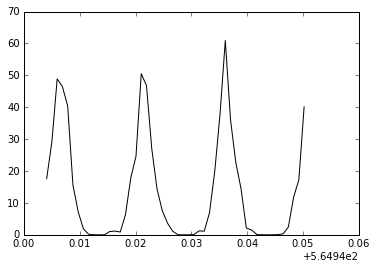

In [52]:
%matplotlib inline

import numpy as np
from scipy.stats import norm
import astropy.constants as const 
import astropy.units as u
import matplotlib
import matplotlib.pylab as plt
import pickle

class LFC:
    '''
    LFC class
    Call with the pump laser frequency [GHz], offset frequency [GHz], and repetition rate [GHz]
    '''
    def __init__(self, pump_wav, offset_freq, rep_rate):
        self.pump_freq = self.convertWavFreq(float(pump_wav))
        self.offset_freq = float(offset_freq)
        self.rep_rate = float(rep_rate)
        
    def getModeSpacing(self):
        '''
        Returns LFC mode spacing
        '''
        return self.rep_rate
    
    def convertWavFreq(self, wavelength):
        '''
        Input wavelength in nm, return frequency in GHz
        '''
        # Check if array
        if isinstance(wavelength, np.ndarray):
            return const.c * u.s / u.m  / wavelength.astype(float)  # Hack to get rid of units
        else: return const.c * u.s / u.m  / float(wavelength)  # Hack to get rid of units
    
    def convertFreqWav(self, frequency):
        '''
        Input frequency in GHz, return wavelength in nm
        '''
        # Check if array
        if isinstance(frequency, np.ndarray):
            return const.c * u.s / u.m / frequency.astype(float)  # Hack to get rid of units
        else: return const.c * u.s / u.m / float(frequency)  # Hack to get rid of units
    
    def getClosestCombLine(self, wavelength):
        '''
        Find closest comb line to specified wavelength.
        '''
        freq = self.convertWavFreq(float(wavelength))
        if (freq < self.pump_freq):
            offset = (self.pump_freq - freq) % self.rep_rate
        elif (freq > self.pump_freq):
            offset = (freq - self.pump_freq) % self.rep_rate
        else:            
            offset = 0.0
        return self.convertFreqWav(freq + offset)
        
    def getWavelengths(self, start_wav, end_wav):
        '''
        Return array of n_points that defines the positions of comb lines in wavelength space
        '''
        start_freq = self.convertWavFreq(start_wav)
        end_freq = self.convertWavFreq(end_wav)
        n_points = int(np.around(np.abs(start_freq - end_freq) / self.rep_rate))
        freqs = np.zeros([1, n_points])
        start_pnt = self.convertWavFreq(self.getClosestCombLine(start_wav))
        for n in range(n_points):
            freqs[0, n] = start_pnt - n * self.rep_rate
        return self.convertFreqWav(freqs)

class Spectrograph:
    '''
    Spectrograph class
    Call with resolution, sampling [pixels], QE, throughput
    '''
    def __init__(self, resolution, sampling, QE, throughput):
        self.res = float(resolution)
        self.samp = float(sampling)
        self.qe = float(QE)
        self.thruput = float(throughput)
        
    def getSampling(self):
        '''
        Public access for pixel sampling
        '''
        return self.samp
        
    def getPlateFactor(self, wavelength):
        '''
        Return spectrograph plate factor at given wavelength
        '''
        return wavelength / (self.res * self.samp)
    
    def getThroughput(self, wavelength):
        '''
        Return spectrograph throughput at given wavelength
        '''
        return self.qe * self.thruput
    
    def getPixelBoundary(self, short_wav, long_wav):
        '''
        Returns array with pixel boundaries
        '''
        pixel_boundary = np.array([short_wav])
        while (pixel_boundary[-1] < long_wav): 
            pixel_boundary = np.append(pixel_boundary, pixel_boundary[-1] + self.getPlateFactor(pixel_boundary[-1]))
        return pixel_boundary
    
    def getOrderWavelengths(self, order_num):
        '''
        Returns record array for specified order, only orders 108-110 suppported currently
        Call with order number [108-110] and LFC instance
        '''
        if (order_num == 108):
            #order = np.rec.array([(564.84945, 567.47666, 570.10387, 'Wavelength'),
            #                 ])
            wave = np.array([564.84945, 567.47666, 570.10387])
            
        elif (order_num == 109):
            #order = np.rec.array([(559.69123, 562.27045, 564.84967, 'Wavelength'),
            #                  ])                
            wave = np.array([559.69123, 562.27045, 564.84967])
        elif (order_num == 110):
            #order = np.rec.array([(554.62636, 557.15890, 559.69144, 'Wavelength'),
            #                 ])
            wave = np.array([554.62636, 557.15890, 559.69144])
        else: 
            print "Incompatible order number"
            return -1
        
        return wave
        
    def getData(self, wave, lfc_inst, intensity):    
        bounds = self.getPixelBoundary(wave[0], wave[2])
        data = np.zeros(bounds.size-1)  # empty pixel array
        # find lfc lines for given order, extend beyond order to allow for overlap
        lfc_loc = lfc_inst.getWavelengths(wave[0]-self.getPlateFactor(wave[0])*20, wave[2]+self.getPlateFactor(wave[2])*20)
        for n in range(data.size):
            # for each pixel, compute CDF(pix_start) - CDF(pix_end) with array of lfc line locations acting as Gaussian series
            data[n] = np.sum( intensity * (self.area_under_norm_dist(bounds[n], bounds[n+1], lfc_loc, 
                                                self.getPlateFactor(bounds[n])*self.getSampling())
                            ))
        mean_wave_pix = bounds[0:bounds.size-1] + (bounds[1:bounds.size] -bounds[0:bounds.size-1])/2.0
        return data, mean_wave_pix                            
    
    def area_under_norm_dist(self, a, b, loc, fwhm):
        # Returns area under normal distribution centered at loc with fwhm on boundary (a,b)
        # calculates CDF(b) - CDF(a) 
        # loc may be an array
        sigma = fwhm / (2.0*np.sqrt(2.0*np.log(2)))  # [pixels]
        area = norm.cdf(b, loc, scale=sigma) - norm.cdf(a, loc, scale=sigma)
        return area




spx = Spectrograph(150000.0, 4.0, 1.0, 1.0)
lfc = LFC(600.0, 10.0, 14.0)

# get information on orders
order_info = np.zeros([3,3])
order_info[0,:] = spx.getOrderWavelengths(110)
order_info[1,:] = spx.getOrderWavelengths(109)
order_info[2,:] = spx.getOrderWavelengths(108)

# Setup SNR
signal = 100
noise = True

# Go through each order, create data and get lfc truth values
data, wavelengths = spx.getData(order_info[0,:], lfc, signal)
if noise: data += np.random.poisson(data)
pixel_data110 = np.array([wavelengths, data])
lfc_truth110 = np.array([lfc.getWavelengths(order_info[0,0]-spx.getPlateFactor(order_info[0,0])*20, 
                                            order_info[0,2]+spx.getPlateFactor(order_info[0,2])*20)])

data, wavelengths = spx.getData(order_info[1,:], lfc, signal)
if noise: data += np.random.poisson(data)
pixel_data109 = np.array([wavelengths, data])
lfc_truth109 = np.array([lfc.getWavelengths(order_info[1,0]-spx.getPlateFactor(order_info[0,0])*20, 
                                            order_info[1,2]+spx.getPlateFactor(order_info[1,2])*20)])

data, wavelengths = spx.getData(order_info[2,:], lfc, signal)
if noise: data += np.random.poisson(data)
pixel_data108 = np.array([wavelengths, data])
lfc_truth108 = np.array([lfc.getWavelengths(order_info[2,0]-spx.getPlateFactor(order_info[2,0])*20, 
                                            order_info[2,2]+spx.getPlateFactor(order_info[2,2])*20)])

pixel_data = {'order110': pixel_data110, 'order109': pixel_data109, 'order108': pixel_data108}
lfc_truth = {'lfc110': lfc_truth110, 'lfc109': lfc_truth109, 'lfc108': lfc_truth108}
no_noise = {'truth_values': lfc_truth, 'data': pixel_data}
title = '%dnoise.p' % np.sqrt(signal)
pickle.dump(no_noise, open(title, 'wb'))

plt.figure()
plt.plot(pixel_data108[0,100:150], pixel_data108[1,100:150], 'k')
#plt.axis([mean_wav[0], mean_wav[-1], 0, 25])




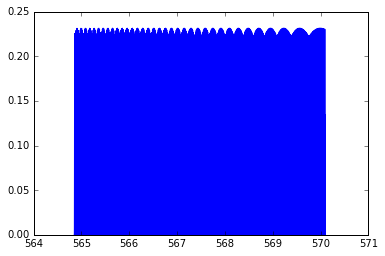

In [42]:
%matplotlib inline

import pickle
import matplotlib
import matplotlib.pylab as plt

d = pickle.load(open('no_noise.p', 'rb'))
plt.figure()
plt.plot(d['data']['order108'][0,:], d['data']['order108'][1,:])